In [43]:
import torch    
import json 
from ptlpinns.models import model, transfer
from ptlpinns.perturbation import LPM, standard
from ptlpinns.odes import forcing, numerical, equations
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

### Load model

In [44]:
name = "overdamped_k15"

overdamped_path = f"/home/dda24/PTL-PINNs/ptlpinns/models/train/{name}"
overdamped_name = f"model_{name}.pth"
overdamped_model, training_log = model.load_model(overdamped_path, overdamped_name)

15 True True False [128, 128, 256]


### Problem definition

In [45]:
N = 5120
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], N)

### Compute latent representations

In [46]:
H_dict = transfer.compute_H_dict(overdamped_model, N=N, bias=True, t_span=t_span)

### Transfer parameters

In [47]:
w_list_transfer = [1, 1, 1, 1, 1]
zeta_list = [5, 10, 30, 60]

def forcing(numpy=False):
    if not numpy:
        def force(t):
            return torch.stack((torch.zeros_like(t), torch.cos(t)), dim=1)
    else:
        def force(t):
            return np.stack((np.zeros_like(t), np.cos(t)), axis=1)
    return force

forcing_list = [forcing(True), forcing(True), forcing(True), forcing(True), forcing(True)]

forcing_1D = lambda t: np.cos(t)
ic_list = [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
epsilon_list = [0.5, 0.5, 0.5, 0.5, 0.5]
p_list = [10]
q = [(3, 1)]

### Numerical solver

In [48]:
numerical_list = []

for zeta in zeta_list:
    ode = equations.ode_oscillator_1D(w_0=w_list_transfer[0], zeta=zeta, forcing_1D=forcing_1D, q=q, epsilon=epsilon_list[0])
    numerical_list.append(numerical.solve_ode_equation(ode, (t_eval[0], t_eval[-1]), t_eval, ic_list[0]))

### PINN

In [49]:
NN_TL_solution, perturbation_solution, _ = transfer.compute_perturbation_solution(w_list_transfer, zeta_list, epsilon_list, p_list, ic_list, forcing_list, H_dict, t_eval, training_log, all_p=True, comp_time=False, solver="standard", power=q)
NN_TL_solution = NN_TL_solution.squeeze()

In [50]:
NN_TL_solution.shape

(5120, 4, 2)

In [51]:
PINN_solution = []

for perturbation_zeta in perturbation_solution:

    perturbation = []
    for perturbation_order in perturbation_zeta:

        perturbation.append(perturbation_order[:, 0])

    PINN_solution.append(standard.calculate_general_series(perturbation, epsilon_list[0]))

zeta: 5, order: 0, mean error absolute: 0.05822672219911064
zeta: 5, order: 1, mean error absolute: 0.3413676215038624
zeta: 5, order: 2, mean error absolute: 0.3413676215038626
zeta: 5, order: 3, mean error absolute: 0.3413676215038626
zeta: 5, order: 4, mean error absolute: 0.3413676215038626
zeta: 5, order: 5, mean error absolute: 0.3413676215038626
zeta: 5, order: 6, mean error absolute: 0.3413676215038626
zeta: 5, order: 7, mean error absolute: 0.3413676215038626
zeta: 5, order: 8, mean error absolute: 0.3413676215038626
zeta: 5, order: 9, mean error absolute: 0.3413676215038626


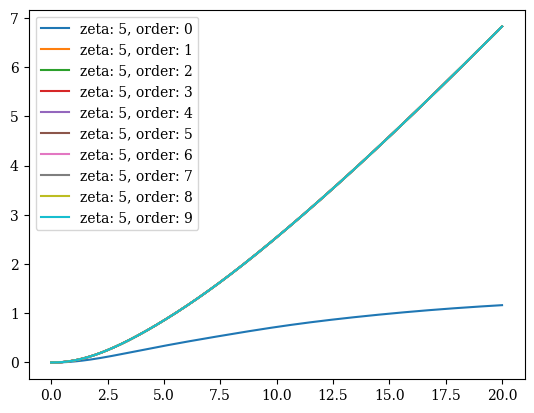

zeta: 10, order: 0, mean error absolute: 0.06638857482350895
zeta: 10, order: 1, mean error absolute: 0.24987350327510435
zeta: 10, order: 2, mean error absolute: 0.2498735032751856
zeta: 10, order: 3, mean error absolute: 0.2498735032751856
zeta: 10, order: 4, mean error absolute: 0.2498735032751856
zeta: 10, order: 5, mean error absolute: 0.2498735032751856
zeta: 10, order: 6, mean error absolute: 0.2498735032751856
zeta: 10, order: 7, mean error absolute: 0.2498735032751856
zeta: 10, order: 8, mean error absolute: 0.2498735032751856
zeta: 10, order: 9, mean error absolute: 0.2498735032751856


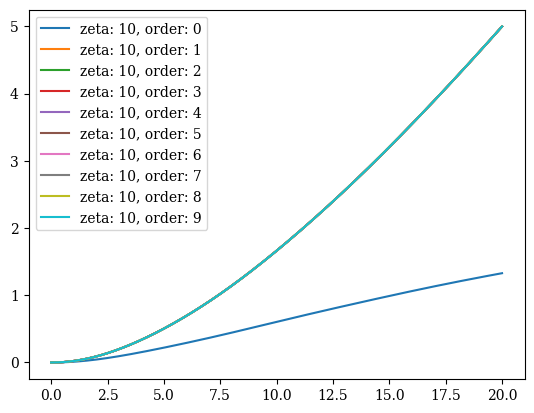

zeta: 30, order: 0, mean error absolute: 0.04891298451529012
zeta: 30, order: 1, mean error absolute: 0.12374075346241334
zeta: 30, order: 2, mean error absolute: 0.12374075346326492
zeta: 30, order: 3, mean error absolute: 0.12374075346326492
zeta: 30, order: 4, mean error absolute: 0.12374075346326492
zeta: 30, order: 5, mean error absolute: 0.12374075346326492
zeta: 30, order: 6, mean error absolute: 0.12374075346326492
zeta: 30, order: 7, mean error absolute: 0.12374075346326492
zeta: 30, order: 8, mean error absolute: 0.12374075346326492
zeta: 30, order: 9, mean error absolute: 0.12374075346326492


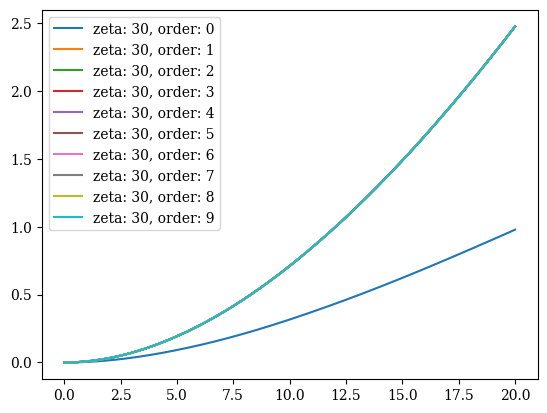

zeta: 60, order: 0, mean error absolute: 0.031390431416375694
zeta: 60, order: 1, mean error absolute: 0.07086611192101959
zeta: 60, order: 2, mean error absolute: 0.07086611192104429
zeta: 60, order: 3, mean error absolute: 0.07086611192104429
zeta: 60, order: 4, mean error absolute: 0.07086611192104429
zeta: 60, order: 5, mean error absolute: 0.07086611192104429
zeta: 60, order: 6, mean error absolute: 0.07086611192104429
zeta: 60, order: 7, mean error absolute: 0.07086611192104429
zeta: 60, order: 8, mean error absolute: 0.07086611192104429
zeta: 60, order: 9, mean error absolute: 0.07086611192104429


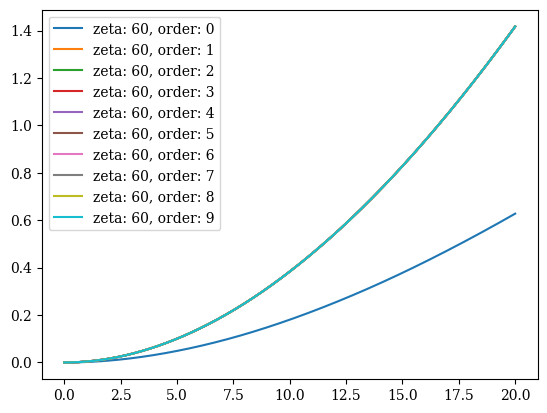

In [52]:
standard.plot_error_by_order(t_eval, PINN_solution, numerical_list, p_list, zeta_list, "zeta")

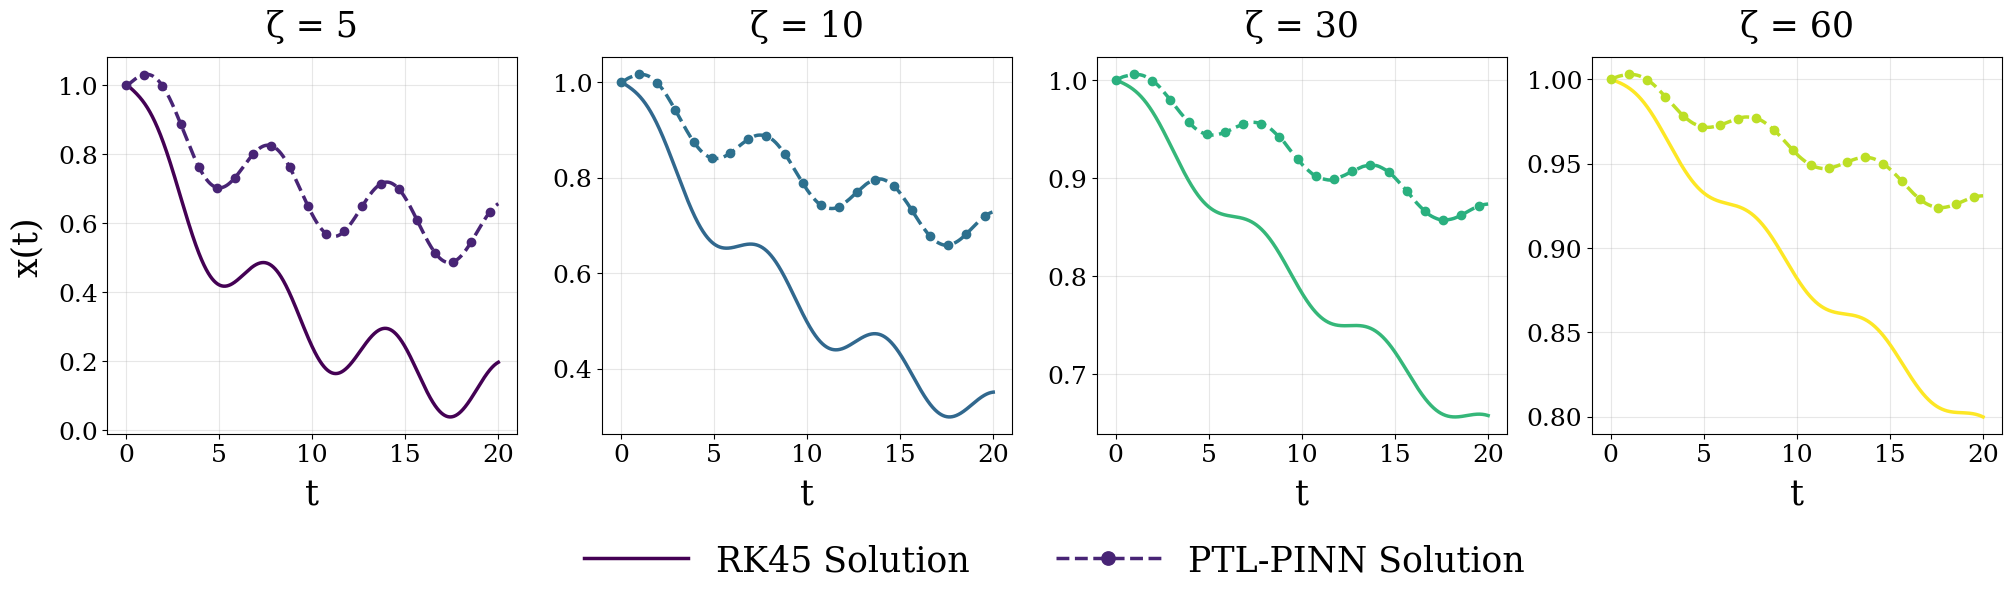

In [53]:
standard.plot_compare_multiple_zeta(t_eval, zeta_list, numerical_list, NN_TL_solution)


zeta: 5, mean Error: 3.414e-01
zeta: 10, mean Error: 2.499e-01
zeta: 30, mean Error: 1.237e-01
zeta: 60, mean Error: 7.087e-02


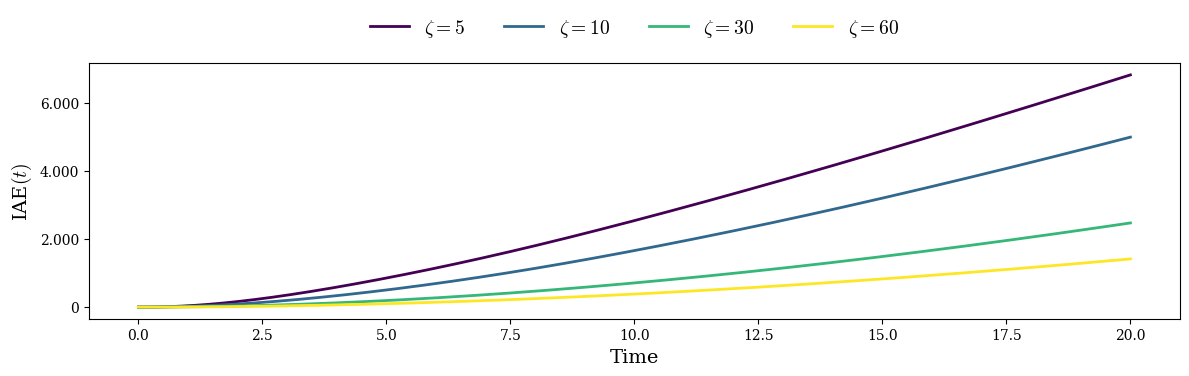

In [54]:
standard.plot_IAE_multiple_zeta(zeta_list, t_eval, NN_TL_solution, numerical_list)